In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import cv2
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
#import resnet
resnet_model = torchvision.models.resnet18(pretrained=True)
#check number of folders in dataset folder


In [ ]:
class RectAngularPadTransform(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, img):
        print(img.size)
        padding = (
            max(0, (img.size[1] - img.size[0]) // 2),
            max(0, (img.size[0] - img.size[1]) // 2)
        )
        #show image
        new_img = new_img = F.pad(img, padding)
        return new_img
    
    def __repr__(self):
        return self.__class__.__name__

In [130]:

#transform images for resnet
transform = transforms.Compose([
    RectAngularPadTransform(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
#load data
dataset = ImageFolder(root='datasets/2023-12-07-12-57', transform=transform)
targets = dataset.targets
#split data into train, test, val
#70-20-10
train_val_idx, test_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True,stratify=targets, random_state=42)
print(type(train_val_idx))
train_val_idx_list = train_val_idx.tolist()
train_val_stratifier = np.take(targets,train_val_idx_list)
#targets[train_val_idx_list]
train_idx, validation_idx = train_test_split(train_val_idx,test_size=0.125,shuffle=True,stratify=train_val_stratifier, random_state=42)
#adjust classifier to match number of classes +1 for uncertain
resnet_model.fc = nn.Linear(512, len(dataset.classes) + 1)
#load data into dataloader
batch_size = 64

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
validation_sampler = torch.utils.data.SubsetRandomSampler(validation_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler)

<class 'numpy.ndarray'>


In [134]:
#plot class distribution in dataset
class_counts = {class_idx: 0 for class_idx in range(len(dataset.classes))}

for _, label in dataset:
    class_counts[label] += 1

# Plot the distribution
classes = [dataset.classes[idx] for idx in class_counts.keys()]
counts = [class_counts[idx] for idx in class_counts.keys()]

plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in Dataset')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()

(2300, 1900)
(2300, 1900)
(768, 576)
(768, 576)
(768, 576)
(2300, 1900)
(2300, 1900)
(2300, 1900)
(2736, 1824)
(2048, 1536)
(2592, 1728)
(2592, 1728)
(2736, 1824)
(2414, 2416)
(2592, 1728)
(1936, 1296)
(2048, 1536)
(2736, 1824)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046, 2572)
(3046

KeyboardInterrupt: 

{0: 1, 1: 10, 2: 65, 3: 30, 4: 3, 5: 28, 6: 31, 7: 19, 8: 33, 9: 1}
['Bietti crystalline dystrophy', 'Maculopathy', 'Normal', 'Pathological myopia', 'Retinitis pigmentosa', 'age-related macular degeneration', 'cataract', 'diabetic retinopathy', 'glaucoma', 'myopia retinopathy']


{'Bietti crystalline dystrophy': 0,
 'Maculopathy': 1,
 'Normal': 2,
 'Pathological myopia': 3,
 'Retinitis pigmentosa': 4,
 'age-related macular degeneration': 5,
 'cataract': 6,
 'diabetic retinopathy': 7,
 'glaucoma': 8,
 'myopia retinopathy': 9}

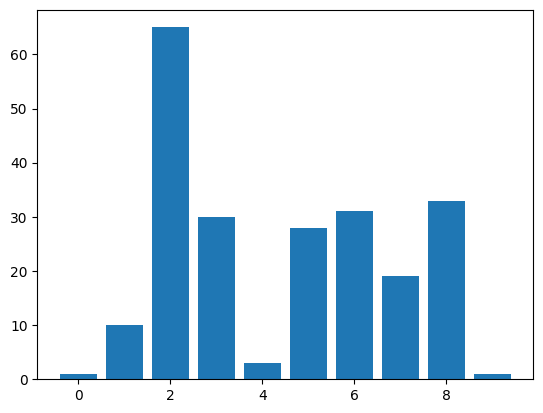

In [131]:
#plot distribution in dataloaders
#plot distribution of classes in each dataloader
#Count occurrences of each class in the DataLoader
class_counts = {class_idx: 0 for class_idx in range(len(dataset.classes))}
data = np.take(dataset.targets,validation_sampler.indices)
for class_idx in class_counts:
    class_counts[class_idx] = np.count_nonzero(data == class_idx)
print(class_counts)
#put class names on x axis
class_names = dataset.classes
print(class_names)
x = np.arange(len(class_names))
#plot
plt.bar(x, class_counts.values())
dataset.class_to_idx

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
#plot one example with and without the transform
#pathn to example image
path = 'datasets/2023-12-07-12-57/age-related macular degeneration/43_left.jpg'
img = cv2.imread(path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img_rgb.shape)
#show image
plt.imshow(img_rgb)
plt.show()
#transform image to tensor
pil_img = Image.open(path).convert('RGB')
pil_img = transform(pil_img)
#show image
plt.imshow(pil_img.permute(1,2,0))


In [ ]:
#train model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model.to(device)
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    train_loss = 0
    train_acc = 0
    resnet_model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #forward
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #calculate loss and accuracy
        train_loss += loss.item() * images.size(0)
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        train_acc += acc.item() * images.size(0)
    avg_train_loss = train_loss / len(train_loader.sampler)
    avg_train_acc = train_acc / len(train_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f}'.format(epoch+1, avg_train_loss, avg_train_acc))